# Polynômes de chaos : application au cas de la poutre encastrée


## Résumé

Dans ce notebook, nous présentons la décomposition en chaos polynomial du cas de la poutre encastrée. Nous montrons comment obtenir les indices de Sobol' à partir d'un chaos polynomial.

## Déviation verticale d'une poutre encastrée

On considère le modèle de [poutre encastrée](https://github.com/mbaudin47/otsupgalilee-eleve/blob/master/0-Deroulement/Poutre-encastree.md).

## Un guide pour le chaos polynomial creux dans OpenTURNS

Voici les étapes principales et les objets pour créer un polynôme de chaos creux par régression.
* Créer un plan d'expériences (de type `Sample`) et évaluer les sorties de la fonction $g$
* Créer la base polynomiale multivariée avec la classe `OrthogonalProductPolynomialFactory`. 
  * La règle par défaut `StandardDistributionPolynomialFactory` sélectionne automatiquement la famille de polynômes en fonction de la distribution ou bien l'orthogonalise si elle n'existe pas. Si nécessaire, personnaliser la famille polynomiale univariée pour chaque marginale (par exemple, pour la variable log-normale). 
  * Si nécessaire, personnaliser la règle d'énumération avec `HyperbolicAnisotropicEnumerateFunction`.
* Choisir une méthode de sélection de modèle avec `LeastSquaresMetaModelSelectionFactory`. 
  * Par défaut, l'algorithme de sélection de modèle permettant de créer la hiérarchie de modèles du plus creux au moins creux est la méthode "Least Angle Regression Stepwise" (LARS). 
  * Par défaut, l'algorithme de choix du meilleur modèle dans la hiérarchie de modèles est la méthode `CorrectedLeaveOneOut`. Si nécessaire, choisir `KFold`. 
* Choisir une règle de calcul des coefficients du polynôme du chaos avec la classe `LeastSquaresStrategy`. Une alternative serait de calculer les coefficients par intégration avec `IntegrationStrategy`.
* Choisir une méthode de troncature pour déterminer combien de coefficients seront retenus dans l'exploration des modèles. La méthode de base est d'utiliser un nombre fixe avec `FixedStrategy`. L'alternative est la classe `SequentialStrategy` dont l'objectif est de conserver au plus un nombre donné de coefficients. 
* Mélangez les ingrédients; votre `FunctionalChaosAlgorithm` est prêt !

Un guide plus complet est disponible dans [guide-chaos-polynomial.md](https://github.com/mbaudin47/otsupgalilee-eleve/blob/master/5-Chaos/guide-chaos-polynomial.md) avec, en particulier, plusieurs méthodes pour améliorer la qualité de prévision du chaos polynomial.

## Pourquoi utiliser une méthode de sélection de modèle

Lorsqu'on utilise le chaos polynomial "classique" ou plein, on peut tenter d'améliorer la qualité du métamodèle en augmentant le degré du polynôme. La difficulté de cette approche est que le nombre de coefficients à estimer augmente très rapidement en fonction de la dimension d'entrée $p$ du vecteur aléatoire $\mathbf{X}$ et du degré $d$ du polynôme. Ce conduit à estimer un grand nombre de coefficients. Si la taille du plan d'expérience est fixée, chaque coefficient est donc de plus en plus mal estimé lorsque le degré augmente. En parallèle, la résolution nécessite de plus en plus de temps CPU lorsqu'on utilise la méthode d'estimation par régression, car le système d'équations à résoudre est de plus en plus grand. Enfin, cela conduit au sur-apprentissage: le méta-modèle possède une grande erreur de prédiction lorsqu'on le teste sur un plan d'expérience de validation différent du plan d'expériences utilisé pour l'apprentissage.

Plus de détails sur le thème du sur-apprentissage et la nécessité de la sélection de modèle sont disponibles dans [Over-fitting-model-selection.ipynb](https://github.com/mbaudin47/otsupgalilee-eleve/blob/master/5-Chaos/Over-fitting-model-selection.ipynb). 

## References

* http://openturns.github.io/openturns/master/auto_meta_modeling/polynomial_chaos_metamodel/plot_chaos_beam_sensitivity_degree.html

# Model definition

In [1]:
import openturns as ot
import openturns.viewer as otv
import numpy as np
import math
import tabulate

In [ ]:
distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)  # en Pa
distributionE.setDescription(["E"])
parametersF = ot.LogNormalMuSigma(300.0, 30.0, 0.0)  # Paramétrage par les moments (en N)
distributionF = ot.ParametrizedDistribution(parametersF)
distributionF.setDescription(["F"])
distributionL = ot.Uniform(2.50, 2.60)  # en m
distributionL.setDescription(["L"])
distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # en m^4
distributionI.setDescription(["I"])

inputDistribution = ot.JointDistribution([distributionE, distributionF, distributionL, distributionI])

inputDimension = 4  # Dimension du vecteur d'entrée
outputDimension = 1  # Dimension du vecteur de sortie


def functionBeam(X):
    E, F, L, I = X
    Y = F * L**3 / (3 * E * I)
    return [Y]


g = ot.PythonFunction(inputDimension, outputDimension, functionBeam)
g.setInputDescription(inputDistribution.getDescription())

**Remarque.** Cette implémentation repose sur la classe `PythonFunction`. Pour un modèle analytique de cette nature, l’usage de la classe `SymbolicFunction` s’avérerait plus performant, car elle permet une évaluation vectorisée native et fournit le gradient analytique de la fonction. Si cette précision algorithmique n'influe pas directement sur l'estimation des coefficients du chaos polynomial, la `SymbolicFunction` réduit significativement les temps de calcul sur des plans d'expériences de grande taille. Toutefois, la `PythonFunction` offre une versatilité indispensable dès lors que le modèle intègre des bibliothèques tierces ou des solveurs externes, comme un code d'éléments finis. Le choix de cette classe dans cet exercice revêt donc un caractère purement didactique : il s'agit de démontrer une méthodologie générique et extensible à des modèles industriels complexes, bien que cette option ne constitue pas la solution optimale pour ce cas d'espèce.

## Créer une décomposition en polynômes du chaos

La fonction suivante calcule un chaos parcimonieux avec une règle d’énumération linéaire. Le lecteur curieux peut lire le contenu de la fonction, mais cela n’est pas obligatoire. La fonction est extraite de la documentation d'OpenTURNS (voir [plot_pce_design.html](https://openturns.github.io/openturns/latest/auto_numerical_methods/general_methods/plot_pce_design.html)) sans modification. Cela explique pourquoi sa documentation est en anglais.


In [3]:
def computeSparseLeastSquaresFunctionalChaos(
    inputTrain,
    outputTrain,
    multivariateBasis,
    basisSize,
    inputDistribution,
    sparse=True,
):
    """
    Create a sparse polynomial chaos based on least squares.

    * Uses the enumerate rule in multivariateBasis.
    * Uses the LeastSquaresStrategy to compute the coefficients based on
      least squares.
    * For a sparse PCE, uses LeastSquaresMetaModelSelectionFactory to use 
      the LARS selection method.
      Otherwise, use PenalizedLeastSquaresAlgorithmFactory.
    * Uses FixedStrategy in order to keep all the selected coefficients.

    Parameters
    ----------
    inputTrain : ot.Sample
        The input design of experiments.
    outputTrain : ot.Sample
        The output design of experiments.
    multivariateBasis : ot.Basis
        The multivariate chaos basis.
    basisSize : int
        The size of the function basis.
    inputDistribution : ot.Distribution.
        The distribution of the input variable.
    sparse: bool
        If True, create a sparse PCE.

    Returns
    -------
    result : ot.PolynomialChaosResult
        The estimated polynomial chaos.
    """
    sampleSize = inputTrain.getSize()
    if basisSize > sampleSize:
        raise ValueError(
            f"The number of coefficients = {basisSize} is larger than the "
            f"sample size {sampleSize}"
        )
    if sparse:
        selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    else:
        selectionAlgorithm = ot.PenalizedLeastSquaresAlgorithmFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, basisSize)
    chaosAlgorithm = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, inputDistribution, adaptiveStrategy, projectionStrategy
    )
    chaosAlgorithm.run()
    chaosResult = chaosAlgorithm.getResult()
    return chaosResult

La fonction suivante simplifie la création d'un métamodèle de chaos polynomial dans le cas où l'utilisateur souhaite spécifier directement le degré polynomial. De plus, la base multivariée orthogonal est créée grâce à au mécanisme d'orthogonalisation par défaut dans la bibliothèque. Bien qu'elle soit moins générale que la précédente, elle peut être pratique dans certains contextes, en particulier dans une situation pédagogique.

In [4]:
def computeSparseLeastSquaresChaosFromDegree(
    inputTrain, outputTrain, totalDegree, inputDistribution, sparse=True
):
    """
    Crée un polynôme du chaos creux par moindres carrés.

    Voir computeSparseLeastSquaresFunctionalChaos() pour le 
    détail du calcul.

    Parameters
    ----------
    inputTrain : ot.Sample
        Le plan d'expérience des entrées
    outputTrain : ot.Sample
        Le plan d'expérience des sorties
    totalDegree : int
        Le degré total maximal du chaos
    inputDistribution : ot.Distribution
        La loi du vecteur aléatoire en entrée
    sparse: bool
        Si True, crée un polynôme du chaos creux avec sélection LARS

    Returns
    -------
    result : ot.FunctionalChaosResult
        La décomposition en polynômes du chaos
    """
    inputDimension = inputDistribution.getDimension()
    marginals = [inputDistribution.getMarginal(i) for i in range(inputDimension)]
    multivariateBasis = ot.OrthogonalProductPolynomialFactory(marginals)
    enumerateFunction = multivariateBasis.getEnumerateFunction()
    basisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
    result = computeSparseLeastSquaresFunctionalChaos(
        inputTrain,
        outputTrain,
        multivariateBasis,
        basisSize,
        inputDistribution,
        sparse=sparse,
    )
    return result

## Calcul du nombre de coefficients

Soit $d \in \mathbb{N}$ la dimension du vecteur aléatoire $\boldsymbol{X}$ en entrée et soit $p \in \mathbb{N}$ le degré polynomial. Le nombre de coefficients d'une décomposition en polynômes du chaos de degré $p$ en dimension $d$ est donné par le coefficient binomial (voir (Le Maître & Knio, 2010) page 34, eq.2.53) :
$$
n_c = {p + d \choose p} = \frac{(p + d)!}{p!d!}.
$$

**Références**

- Le Maître, O. and Knio, O. (2010). _Spectral Methods for Uncertainty Quantification with Applications to Computational Fluid Dynamics._ Springer Series Scientific Computation.


In [5]:
def computeNumberOfCoefficientsPCE(dimension, degree):
    """
    Retourne le nombre de coefficients d'un chaos polynomial (PCE).

    Il s'agit du coefficient binomial de (dimension + degré, degré).

    Parameters
    ----------
    dimension : int
        La dimension d'entrée.
    degree : int
        Le degré du polynôme.

    Returns
    -------
    n : int
        Le nombre de coefficients.
    """
    n = math.comb(dimension + degree, degree)
    return n

Le script suivant génère une table contenant le nombre de coefficients d'une décomposition en polynômes du chaos plein en fonction du degré polynomial.

In [6]:
print(f"Dimension d'entrée = {inputDimension}")
dataset = []
maximumDegree = 12
for degree in range(1, maximumDegree + 1):
    numberOfCoefficients = computeNumberOfCoefficientsPCE(inputDimension, degree)
    dataset.append([degree, numberOfCoefficients])
tabulate.tabulate(dataset, tablefmt="html", headers=["Degré", "Nbre Coeffs."])

Dimension d'entrée = 4


Degré,Nbre Coeffs.
1,5
2,15
3,35
4,70
5,126
6,210
7,330
8,495
9,715
10,1001


On observe que pour estimer les coefficients d'un polynôme de degré 4, il faut au moins 70 observations. Si nous choisissons d'utiliser 50 observations, nous pouvons estimer les coefficients d'un polynôme de degré 3, ce qui mène à 35 coefficients. Avec 100 observations, on peut estimer les coefficients d'un polynôme de degré 4, ce qui mène à 70 coefficients, mais on ne peut pas estimer les coefficients d'un polynôme de degré 5 car le nombre de paramètre est alors supérieur au nombre d'observations. Dans ce cas, la décomposition en polynômes du chaos plein est sur-déterminée : le problème de moindres carrés linéaire possède dans ce cas une infinité de solutions. Une solution serait d'utiliser une méthode de sélection de modèle, menant à un chaos creux.

## Décomposition en polynômes du chaos

On crée la base polynomiale multivariée par tensorisation de polynômes univariés avec la règle d'énumération linéaire par défaut.

In [7]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [distributionE, distributionF, distributionL, distributionI]
)

On crée un échantillon d'apprentissage Monte-Carlo simple de taille $n = 50$. 

In [ ]:
trainingSampleSize = 100  # Taille du plan d'expérience

inputTrain = inputDistribution.getSample(trainingSampleSize)
outputTrain = g(inputTrain)

totalDegree = 4  # Degré polynomial
sparse = False  # Ajuster ceci. Que se passe-t-il si on utilise sparse=True?
result = computeSparseLeastSquaresChaosFromDegree(
    inputTrain, outputTrain, totalDegree, inputDistribution
)
result

Index,Multi-index,Coeff.
0,"[0,0,0,0]",0.1706912
1,"[1,0,0,0]",-0.004303592
2,"[0,1,0,0]",0.01706906
3,"[0,0,1,0]",0.00579454
4,"[0,0,0,1]",-0.008245945
5,"[2,0,0,0]",0.000133207
6,"[1,1,0,0]",-0.0004296863
7,"[1,0,1,0]",-0.0001463693
8,"[1,0,0,1]",0.000207014
9,"[0,1,1,0]",0.0005789537


La méthode `getMetaModel` retourne une fonction permettant d'évaluer le métamodèle.

In [9]:
metamodel = result.getMetaModel()
type(metamodel)

openturns.func.Function

## Valider le méta-modèle

Avant d'utiliser le méta-modèle, il est nécessaire de valider sa qualité. Pour vérifier la qualité du métamodèle, nous créons un échantillon de test. Puisque c'est un modèle physique peu coûteux, nous choisissons un échantillon de test de taille égale à 1000, ce qui est relativement grand. En pratique, on utilise généralement un échantillon de taille relativement grande pour l'apprentissage et de taille un peu moindre pour la validation. Dans cet exemple, nous avons choisi d'utiliser une grande taille pour l'échantillon de validation dans le but d'estimer le score Q² avec précision. Une alternative consiste à utiliser la validation croisée analytique « _leave-one-out_ ».

In [ ]:
testSampleSize = 1000  # Taille du plan d'expérience de validation
inputTest = inputDistribution.getSample(testSampleSize)
outputTest = g(inputTest)

La classe `MetaModelValidation` permet de valider le métamodèle sur une base de validation.

In [11]:
val = ot.MetaModelValidation(outputTest, metamodel(inputTest))

La méthode `computeR2Score` retourne la valeur du score $Q^2$ sur l'échantillon de test. 

In [12]:
Q2 = val.computeR2Score()[0]
Q2

0.9999998496233106

Le métamodèle est ici d'excellente qualité, puisque le $Q^2$ est supérieur à 99%. Cela signifie que moins de 1% de la variance de la sortie est perdue en substituant le métamodèle au modèle. 

Pour valider graphiquement la qualité du métamodèle, nous utilisons la méthode `drawValidation` qui affiche en abscisse les valeurs du modèle et en ordonnée les valeurs du métamodèle. Le métamodèle est de qualité si les points sont proches de la première bissectrice, indiquée en rouge sur le graphique. En effet, cela signifie que les prédictions du métamodèle sont proche des observations du modèle. 

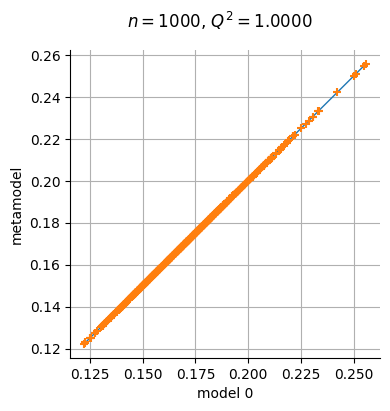

In [ ]:
graph = val.drawValidation()
graph.setTitle(rf"$n = {testSampleSize}$, $Q^2 = {Q2:.4f}$")
view = otv.View(graph, figure_kw={"figsize": (4.0, 4.0)})

La validation est satisfaisante : la plupart des points sont proches de la première bissectrice. Seuls quelques points associés à des grandes déviations sont un peu plus éloignés. 

## Moyenne et variance du chaos polynomial

On peut ensuite obtenir la moyenne et l'écart-type du polynôme du chaos en utilisant la classe `FunctionalChaosRandomVector`.  

In [14]:
chaosRV = ot.FunctionalChaosRandomVector(result)
mean = chaosRV.getMean()[0]
variance = chaosRV.getCovariance()[0, 0]
stdDev = np.sqrt(variance)
print(f"Moyenne = {mean:.4f}")
print(f"Écart-type = {stdDev:.4f}")

Moyenne = 0.1707
Écart-type = 0.0203


Comme pour tout autre `RandomVector`, on peut utiliser la méthode `getSample()` pour produire un échantillon de la sortie du polynôme du chaos.

In [15]:
chaosRV.getSample(5)

,v0
0,0.1648841
1,0.2074614
2,0.1728438
3,0.1617192
4,0.1734367


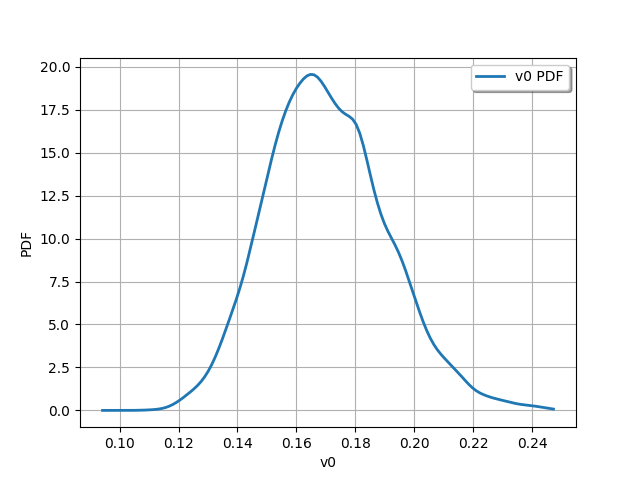

In [16]:
outputBigSample = chaosRV.getSample(10000)  # ⚠️ Utilise le métamodèle, pas le modèle.
kernel2 = ot.KernelSmoothing()
fittedDist = kernel2.build(outputBigSample)
fittedDist.drawPDF()

## Analyse de sensibilité

On souhaite estimer les indices de Sobol' issus de la décomposition en chaos polynomial avec la classe `FunctionalChaosSobolIndices`. Le « _pretty-print_ » permet d'afficher les données les plus importantes, c'est à dire la dimension d'entrée et de sortie, la taille de la base fonctionnelle polynomiale, la moyenne, l'écart-type ainsi que les multi-indices triés par part de variance décroissante. 

In [17]:
chaosSI = ot.FunctionalChaosSobolIndices(result)
chaosSI

class=FunctionalChaosSobolIndices functional chaos result=class=FunctionalChaosResult derived from  metaModel=class=Function name=Unnamed implementation=class=ComposedFunction name=Unnamed description=[E,F,L,I,y0] left function=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,v0] evaluationImplementation=class=DualLinearCombinationEvaluation functions=[class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[1.7021,2.88048],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[-10,0.0333333],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[0,1.73205],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[0.649519,2.81458]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=3 values=[0.0699731,5.45791,6.71742],class=UniVariatePolynomial coefficients=

On observe que la variable ayant l'indice de Sobol total le plus grand est la seconde variable $F$ : son indice de Sobol' du premier ordre est égal à 0.77. De plus, le multi-indice $(0, 1, 0, 0)$ est associé à une part de variance égale à 0.77 : en d'autres termes, le polynôme de degré 1 en la variable standardisée associée à $F$ génère 77% de la variance.

La classe `SobolIndicesAlgorithm` peut être utilisée pour dessiner les indices de Sobol'. 

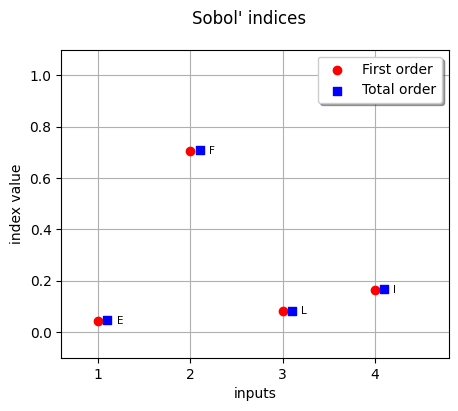

In [18]:
first_order = [chaosSI.getSobolIndex(i) for i in range(inputDimension)]
total_order = [chaosSI.getSobolTotalIndex(i) for i in range(inputDimension)]
inputNames = g.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(inputNames, first_order, total_order)
view = otv.View(graph, figure_kw={"figsize": (5.0, 4.0)})

On observe que la variable la plus influente est **F**, qui explique plus de 70% de la variance de la sortie du modèle physique. La seconde variable la plus importante est la variable **I**. La variable **E** ne contribue pas beaucoup à la variance de la sortie. En d'autres termes, on pourrait réduire la dimension d'entrée du modèle à 3 variables en remplaçant **E** par une constante sans affecter beaucoup la variabilité de la sortie.

On observe qu'il y a peu d'interactions entre les variables puisque chaque indice de Sobol' total est voisin de son indice du premier ordre. En conséquence, la fonction est presque additive, c'est-à-dire qu'elle est la somme de quatre fonctions qui ne dépendent que d'une seule variable :

$$
h(Z_E, Z_F, Z_L, Z_I) = h_0 + h_E(Z_E) + h_F(Z_F) + h_L(Z_L)  + h_I(Z_I)
$$

où $Z_E, Z_F, Z_L$ et $Z_I$ sont les variables aléatoires standardisées correspondant aux variables physiques **E**, **F**, **L** et **I** et $h = g\circ T^{-1}$ est le modèle physique transformé. 

Une des conséquences des remarques précédentes est que la méthode d'échantillonnage quasi Monte-Carlo pourrait être particulièrement efficace dans ce contexte. De plus, une méthode de quadrature comme la quadrature de Gauss tensorisée ou la quadrature de Smolyak pourrait être utilisée pour estimer les coefficients avec une efficacité importante.

## Liste des exercices


* Exercice 1 : Sensibilité à la taille du plan d'expériences d'apprentissage
* Exercice 2 : Sensibilité au degré total
* Exercice 3 : Pourquoi éviter le calcul du R²
* Exercice 4 : Validation croisée analytique
* Exercice 5 : Décroissance des coefficients
* Exercice 6 : Énumération hyperbolique et plan d'expériences de taille 25
* Exercice 7 : Nombre d'observations et nombre de paramètres
* Exercice 8 : Décomposition en polynômes du chaos creux
* Exercice 9 : Calculer la moyenne et l'écart-type du chaos polynomial
* Exercice 10 : Créer un polynôme de Wiener-Hermite
* Exercice 11 : Approximation de la distribution de la sortie


## Exercice 1 : Sensibilité à la taille du plan d'expériences d'apprentissage

Le coefficient de prédictivité $Q^2$ est sensible à deux paramètres essentiels de la méthode:

* la taille du plan d'expériences d'apprentissage ;
* le degré du polynôme.

Dans cet exercice, on souhaite étudier la sensibilité à la taille du plan d'expérience d'apprentissage.

**Questions**

* Utiliser un plan d'expériences d'apprentissage de taille `N = 25`. Exécuter à nouveau l'analyse. Répéter l'opération avec `N = 50`.
* Calculer le coefficient de prédictivité $Q^2$ (noter la valeur numérique).
* Afficher le graphique de validation du métamodèle. Que peut-on conclure ?
* Exécuter à nouveau l'analyse pour voir l'influence de l'échantillon d'apprentissage sur les résultats. 
* Utiliser un plan d'expériences de taille `N = 100`. Exécuter à nouveau l'analyse : observer l'impact sur  les résultats numériques. 
* Etudier la sensibilité du coefficient de prédictivité en fonction de la taille du plan d'expériences et du degré du polynôme. Pour chaque combinaison testée, relever la valeur du coefficient de prédictivité $Q^2$. Pour cela, compléter le tableau suivant:

| Taille du plan | Degré du polynôme | $Q^2$ |
|--|--|--|
| 50 | 1 | TODO |
| 50 | 2 | TODO |
| 50 | 5 | TODO |
| 25 | 5 | TODO |
| 100 | 5 | TODO |


* Pouvez-vous identifier 5 méthodes pour améliorer la qualité du métamodèle ?

## Exercice 2 : Sensibilité au degré total


Le degré total du chaos polynomial est un paramètre libre que l'utilisateur doit ajuster pour obtenir les prévisions de la meilleure qualité possible. Pour cela, la méthode consiste à faire varier le degré total entre 1 et une valeur maximale inférieure ou égale au nombre d'observations. Pour un degré total donné, on utilise une méthode de validation pour calculer une métrique d'adéquation comme le score Q² par exemple. Le métamodèle sélectionné est celui associé au meilleur score Q².

**Questions**

- On considère un échantillon d'apprentissage de taille **n=1000**.
- Rechercher le degré maximal menant à un nombre de coefficients inférieur ou égal à **n**.
- Faire varier le degré polynomial entre 1 et le degré maximal.
- Pour chaque degré polynomial, utiliser une méthode de validation simple pour estimer le score Q².
- Représenter le score Q² en fonction du degré total.
- Quel est le degré polynomial optimal pour cette taille d'échantillon ?
- Quelles sont les limites de cette approche en termes de choix du degré et en termes d'analyse visuelle du score Q² ?
- Mettre au point une méthode alternative fondée sur la fraction de variance inexpliquée 1-Q².
- Quel est le nombre optimal de coefficients pour cette taille d'échantillon ?

## Exercice 3 : Pourquoi éviter le calcul du R²

L'objectif de cet exercice est de clarifier le rôle d'un plan d'expériences d'apprentissage en comparaison d'un plan d'expériences de validation. À travers le calcul des coefficients $R^2$ et $Q^2$, nous analysons le problème du surapprentissage d'un métamodèle.

Soit $\mathcal{A} = \left\{\boldsymbol{x}^{(j)}_a\right\}_{j=1,...,n}$ un échantillon i.i.d. du vecteur aléatoire $\boldsymbol{X}$ que nous allons utiliser pour la phase d'apprentissage du métamodèle. On note $g$ le modèle et $\widetilde{g}$ le métamodèle. Soient :

$$
y^{(j)}_a = g\left(\boldsymbol{x}^{(j)}_a\right), \qquad \widetilde{y}^{(j)}_a = \widetilde{g}\left(\boldsymbol{x}^{(j)}_a\right)
$$

pour $j \in \{1, \ldots, n\}$ les sorties du modèle et du métamodèle sur la base d'apprentissage. 
Le coefficient $R^2$ est :

$$
R^2 \left(g(\boldsymbol{x}_a), \widetilde{g}(\boldsymbol{x}_a)\right) 
= 1 - \frac{ \sum_{j=1}^n \left( y^{(j)}_a - \widetilde{y}^{(j)}_a \right)^2  }{ \sum_{j=1}^n \left( y^{(j)}_a - \overline{y}_a \right)^2 }
$$

où $\overline{y}_a = \frac{1} {n} \sum_{i=1}^n y^{(j)}_a$. 
Observons que le métamodèle n'est impliqué que dans le numérateur de la fraction. 

Supposons qu'un second plan d'expériences de validation du métamodèle est généré, noté $\mathcal{V} = \left\{\boldsymbol{x}^{(j)}_v\right\}_{j=1,...,n}$. Supposons, de plus, que ce second plan d'expériences de validation est indépendant du premier. L'objectif de ce second plan d'expériences est de tester le métamodèle sur des points d'entrées que le métamodèle n'a pas considéré pour estimer ses coefficients.

Soient $g(\boldsymbol{x}_v)$ et $\widetilde{g}(\boldsymbol{x}_v)$ les sorties du modèle et du métamodèle sur le plan d'expériences de validation. 
Dans ce contexte, le coefficient $Q^2$ est égal au coefficient $R^2$ appliqué au plan d'expériences de validation :

$$
Q^2 = R^2 \left(g\left(\boldsymbol{x}_v\right), \widetilde{g}\left(\boldsymbol{x}_v\right)\right).
$$

Dans le contexte de tout métamodèle, et en particulier du chaos polynomial, il est plus prudent d'utiliser le coefficient $Q^2$ pour vérifier la qualité du métamodèle. En effet, lorsque le nombre de coefficients dans le chaos polynomial est suffisamment grand relativement à la taille du plan d'expériences, le coefficient $R^2$ peut laisser penser à un modèle de bonne qualité (i.e. proche de 1), mais le coefficient $Q^2$ peut révéler un modèle de mauvaise qualité (i.e. proche de 0). Cette situation est caractéristique d'un surapprentrissage.

**Questions**

- Calculer le coefficient $R^2$.
- Calculer le coefficient $Q^2$.
- Qu'observez-vous ?

## Exercice 4 : Validation croisée analytique

Lorsqu'on ne dispose que d'un seul échantillon, la validation du métamodèle peut poser des difficultés. Dans ce contexte, la méthode la plus précise est la validation croisée « _leave-one-out_ » (ou LOO). Toutefois, son coût d'utilisation peut être élevé si la procédure d'estimation des coefficients est coûteuse (par exemple si l'échantillon est suffisamment grand ou que le degré polynomial est élevé). Une solution consiste à utiliser la méthode de validation croisée analytique qui produit le score Q² LOO pour un coût réduit (voir (Blatman, 2009) annexe D page 203 et (Baudin, Borel & Chopard, 2024)).

**Questions**
- Créer une instance de la classe `FunctionalChaosValidation` avec un polynôme de chaos plein.
- Estimer le score Q² par validation croisée LOO.

**Références**

- James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). _Statistical learning. In An introduction to statistical learning: With applications in Python_ (pp. 15-67). Cham: Springer International Publishing.
- *Estimation de l'erreur de prévision du chaos polynomial. Application aux simulations thermo-aérauliques.* Baudin Michaël, Borel Pascal, Chopard Gatien. 6125-3119-2024-00151-FR. EDF R&D. 09/07/2024.
- Géraud Blatman. Chaos polynomial creux et adaptatif pour la propagation d'incertitudes et l'analyse de sensibilité. PhD thesis, Université Blaise Pascal-Clermont-Ferrand II, 2009.

## Exercice 5 : Décroissance des coefficients

La fonction suivante produit un graphique présentant l'évolution de la valeur absolue des coefficients du chaos polynomial en fonction du degré de chaque terme polynomial dans la décomposition.

In [19]:
def plotCoefficientValueVSDegree(polynomialChaosResult):
    """
    Create a plot of total degree vs absolute value of coefficients.

    Parameters
    ----------
    polynomialChaosResult : ot.FunctionalChaosResult
        The polynomial chaos result

    Returns
    -------
    graph : ot.Graph
        A plot.
    """
    basis = polynomialChaosResult.getOrthogonalBasis()
    enumerateFunction = basis.getEnumerateFunction()
    # Get coefficients
    coefficients = polynomialChaosResult.getCoefficients()
    absoluteCoefficient = [abs(coefficients[i][0]) for i in range(len(coefficients))]
    # Get total degree
    indices = result.getIndices()
    numberOfCoefficients = indices.getSize()
    degreeList = []
    for k in range(numberOfCoefficients):
        multiIndex = enumerateFunction(indices[k])
        totalDegree = sum(multiIndex)
        degreeList.append(totalDegree)
    #
    graph = ot.Graph(
        "Polynomial chaos result",
        "Total polynomial degree",
        "Coefficient absolute value",
        True,
    )
    cloud = ot.Cloud(degreeList, absoluteCoefficient)
    graph.add(cloud)
    return graph

**Questions**

* Utiliser la fonction `plotCoefficientValueVSDegree` sur le résultat du chaos polynomial : qu'observez-vous ?

## Exercice 6 : Énumération hyperbolique et plan d'expériences de taille 25

We want to see the behaviour of the hyperbolic enumeration rule and see the result of the polynomial chaos expansion. 

**Questions**

* Use an hyperbolic enumeration with a training sample size equal to $n = 25$. 
* Compute the $Q^2$ coefficient. 
* Plot the metamodel validation graphics.
* Is the quality of the chaos acceptable ?

## Exercice 7 : Nombre d'observations et nombre de paramètres

On souhaite vérifier que le nombre d'observations est suffisant pour estimer correctement les paramètres. 

**Questions**

* Calculer le nombre de paramètres estimés dans le chaos polynomial. Pour cela, utiliser la méthode `getCoefficients` de l'objet `result` pour obtenir les coefficients du chaos polynomial. 
* Calculer le nombre d'observations dans le plan d'expériences. 
* Calculer le ratio entre le nombre d'observations et le nombre de paramètres. 
* La taille du plan d'expériences est-elle suffisante pour estimer les paramètres ?

## Exercice 8 : Décomposition en polynômes du chaos creux

Utiliser une méthode de sélection de modèle peut permettre de réduire le nombre de coefficients à estimer en éliminant les coefficients qui ne permettent pas d'améliorer la qualité des prédictions du métamodèle. Pour cela, la bibliothèque implémente l'algorithme _Least Angle Regression Stepwise_ (ou LARS). Le résultat de la méthode est double : d'une part, une liste d'indices correspondant aux coefficients pertinents, d'autre part une estimation des coefficients sélectionnés. 



L'objectif de cet exercice est d'analyser les résultats de la sélection de modèle dans le but de réaliser un diagnostic de la qualité du métamodèle obtenu.

Considérons le ratio suivant, représentant le taux de parcimonie :
```
1 - numberOfSelectedCoefficients / basisSize
```
où `numberOfSelectedCoefficients` est le nombre de coefficients retenus dans la décomposition par la méthode de sélection de modèle et `basisSize` est le nombre maximal de coefficients associé à la règle d'énumération. Ce ratio entre 0 et 1 représente la proportions de termes retenus dans la méthode de sélection de modèle. 
* Si ce ratio est proche de un, alors c'est que le modèle est très creux car un faible nombre de coefficients suffit pour bien représenter la fonction. Dans ce cas, on aurait peut-être pu obtenir une qualité équivalente en utilisant un calcul moins coûteux en diminuant la valeur de `numberOfSelectedCoefficients / basisSize
`.
* Si ce ratio est proche de zéro, alors c'est que le modèle est très plein car presque tous les coefficients ont été nécessaires pour bien représenter la fonction. Dans ce cas, on devrait peut-être améliorer la qualité en utilisant en augmentant la valeur de `basisSize` (cela sera plus coûteux en termes de temps de calcul, sans nécessairement nécessiter de nouvelles évaluations de la fonction $g$).

L'objectif de cet exercice est d'explorer les différentes méthodes de l'objet `result`, une instance de la classe `FunctionalChaosResult`.



**Questions, partie 1**

* Utiliser la méthode `getIndices` pour créer la variable `indices` contenant la liste des indices des coefficients sélectionnés par la méthode. Afficher ces indices.
* Utiliser la méthode `getSize` de la variable `indices` pour obtenir le nombre de coefficients sélectionnés par la méthode.
* Utiliser la méthode `getCoefficients` pour obtenir la liste des valeurs des coefficients sélectionnés par la méthode. Afficher ces coefficients.
* Calculer le taux `1 - numberOfSelectedCoefficients / basisSize`. Quelle est la valeur obtenue ? Que peut-on conclure relativement à la qualité du métamodèle ?
* La fonction `printCoefficientsTable` suivante utilise la règle d'énumération et le résultat d'un chaos polynomial pour afficher une table présentant les multi-indices, le degré du polynôme associé et la valeur du coefficient. 

In [20]:
def printCoefficientsTable(polynomialChaosResult):
    """
    Print the coefficients of the polynomial chaos.

    Parameters
    ----------
    enumerateFunction : ot.EnumerateFunction
        The enumerate function.
    polynomialChaosResult : ot.PolynomialChaosResult
        The polynomial chaos result.
    """
    basis = polynomialChaosResult.getOrthogonalBasis()
    coefficients = polynomialChaosResult.getCoefficients()
    enumerateFunction = basis.getEnumerateFunction()
    indices = polynomialChaosResult.getIndices()
    numberOfCoefficients = indices.getSize()
    print("# Indice, Multi-indice, Degree : Value")
    for k in range(numberOfCoefficients):
        multiIndex = enumerateFunction(indices[k])
        degree = sum(multiIndex)
        c = coefficients[k][0]
        print(f"#{k}, {multiIndex} ({degree}) : {c}")
    return

Utiliser la fonction `printCoefficientsTable` avec les résultats du calcul. Qu'observez-vous ?


L'utilisation de la méthode de sélection de modèle LARS peut être coûteuse, en particulier si l'on recherche le degré polynomial optimal avec sélection de modèle. Dans ce contexte, on peut procéder en deux étapes.
- Rechercher le nombre optimal de coefficients sans sélection de modèle.
- Avec ce nombre optimal de coefficients, utiliser la méthode LARS pour estimer les coefficients sélectionnés.


La fonction suivante permet de déterminer le degré polynomial qui minimise l'erreur quadratique moyenne. Pour l'évaluer de manière économique, on utilise une méthode de validation croisée LOO analytique.

In [ ]:
def computeBestLeastSquaresPCE(
    X, Y, multivariateBasis, distribution, max_degree=20, sparse=False, verbose=False
):
    """
    Détermine le meilleur degré polynomial par validation croisée.

    Parameters
    ----------
    X : ot.Sample
        Échantillon d'entrée
    Y : ot.Sample
        Échantillon de sortie
    distribution : ot.Distribution
        Distribution du vecteur aléatoire X
    multivariateBasis : ot.Basis
        La base du chaos multivarié.
    max_degree : int, optional
        Degré maximal à explorer
    sparse: bool
        Si True, crée un chaos polynomial parcimonieux.
    verbose : bool
        Si True, affiche les messages intermédiaires.

    Returns
    -------
    best_degree : int
        Le meilleur degré polynomial trouvé
    best_result : ot.FunctionalChaosResult
        Meilleur PCE trouvé
    """
    best_degree = 1
    best_MSE = np.inf
    best_result = None

    # Créer le PCE avec le degré actuel
    enumerateFunction = multivariateBasis.getEnumerateFunction()
    sample_size = X.getSize()
    splitter = ot.LeaveOneOutSplitter(sample_size)

    # Tester différents degrés
    for degree in range(0, max_degree + 1):
        if verbose:
            print(f"Essai du degré = {degree}")
        basisSize = enumerateFunction.getBasisSizeFromTotalDegree(degree)
        if basisSize >= sample_size:
            if verbose:
                print(
                    f"Taille de l'échantillon = {sample_size} mais taille "
                    f"de la base = {basisSize} : arrêt"
                )
            if best_result is None:
                raise ValueError(
                    f"Impossible de trouver un meilleur chaos polynomial pour "
                    f"une taille d'échantillon de {sample_size} "
                    f"avec un degré maximum de {max_degree}"
                )
            break
        result = computeSparseLeastSquaresFunctionalChaos(
            X, Y, multivariateBasis, basisSize, distribution, sparse=sparse
        )

        # Validation croisée
        validation = ot.FunctionalChaosValidation(result, splitter)
        mse = validation.computeMeanSquaredError()[0]
        if verbose:
            print(f"  EQM = {mse}")

        if mse < best_MSE:
            if verbose:
                print(f"  Meilleur chaos polynomial trouvé jusqu'ici : conservé.")
            best_MSE = mse
            best_degree = degree
            best_result = result

    if verbose:
        print(f"Meilleur chaos polynomial trouvé jusqu'ici : " f"degré = {best_degree}")
    return best_degree, best_result


**Questions, partie 2**

Mettre la méthode précédente en oeuvre. Pour cela, utiliser la méthode suivante.

- Utiliser la fonction `computeBestLeastSquaresPCE()` avec l'option `sparse=False` pour calculer le degré optimal.
- Puis, avec le degré optimal identifié, utiliser la fonction `computeSparseLeastSquaresFunctionalChaos()` avec l'option `sparse=True`.

## Exercice 9 : Calculer la moyenne et l'écart-type du chaos polynomial

La classe `FunctionalChaosRandomVector` permet d'obtenir la moyenne et la variance du chaos polynomial. L'objectif de cet exercice est d'implémenter le même service en Python. Pour cela, utiliser le squelette de code suivant, où vous remplacerez les sections `TODO` par du code valide.

```python
def get_PC_mean_sd(functionalChaosResult):
    outputDimension = functionalChaosResult.getMetaModel().getOutputDimension()
    indices = functionalChaosResult.getIndices()
    coefficients = functionalChaosResult.getCoefficients()
    basisSize = indices.getSize()
    variance = ot.Point(outputDimension)
    mean = ot.Point(outputDimension)
    for i in range(outputDimension):
        for k in range(basisSize):
            TODO
    # standard deviation
    stdDev = ot.Point(outputDimension)
    for i in range(outputDimension):
            TODO
    return mean, stdDev
```


**Questions**

- Evaluer la moyenne et l'écart-type grâce à la fonction `get_PC_mean_sd`.
- Comparez les valeurs numériques aux valeurs numériques obtenues par `FunctionalChaosRandomVector`. 

## Exercice 10 : Créer un polynôme de Wiener-Hermite

Un polynôme du chaos de Wiener-Hermite utilise exclusivement les polynômes de Hermite comme base de fonctions. Pour créer la base, on peut utiliser les instructions suivantes.

```python
dimension = inputDistribution.getDimension()
hermiteFactory = ot.HermiteFactory()
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [hermiteFactory] * dimension, enumerateFunction
)
```

**Questions**

- Créer un polynôme du chaos avec cette base multivariée et estimer son score $Q^2$ avec un échantillon de test.
- Qu'observez-vous ?
- Quel pourrait être l'avantage d'une telle méthode ? 
- Quels pourraient être les inconvénients ?

## Exercice 11 : Approximation de la distribution de la sortie

Dans (Blatman, 2009) page 69, l'auteur propose d'approcher la distribution de la sortie du polynôme par une méthode d'estimation par lissage à noyau. Cette méthode permet d'approcher la distribution de la sortie du modèle par une méthode plus précise et moins coûteuse que l'échantillonnage Monte-Carlo simple.

**Questions**

- Créer un polynôme du chaos de degré 5 avec un plan d'expériences Monte-Carlo simple de taille $n = 100$. 
- Créer l'objet `FunctionalChaosRandomVector` associé et générer un échantillon de taille $n = 1000$ de la sortie du polynôme du chaos.
- Utiliser la classe `KernelSmoothing` pour approcher la distribution de la sortie du polynôme. Dessiner cette distribution. 
- Dessiner la distribution approchée par lissage à noyau issue de l'échantillon de taille $n = 100$ utilisé pour l'apprentissage.
- Créer un échantillon de taille $n = 1000$ de la sortie du modèle physique. Utiliser la méthode de lissage à noyau pour approcher la distribution de la sortie du modèle physique. 
- Comparer les deux méthodes précédentes : que peut-on conclure ?

**Référence**

- Géraud Blatman. _"Adaptive sparse polynomial chaos expansions for uncertainty propagation and sensitivity analysis"_. Thèse. Université Blaise Pascal - Clermont II. Octobre 2009.